In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0 : print('Available GPUs: {}'.format(gpus))
else             : print('!!! No GPUs found !!!')

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

Metal device set to: Apple M1 Pro


2021-12-14 16:47:30.976135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-14 16:47:30.976239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


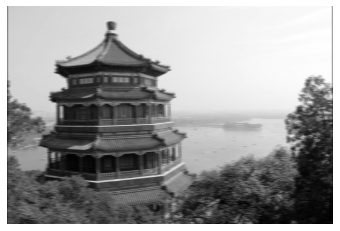

In [4]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

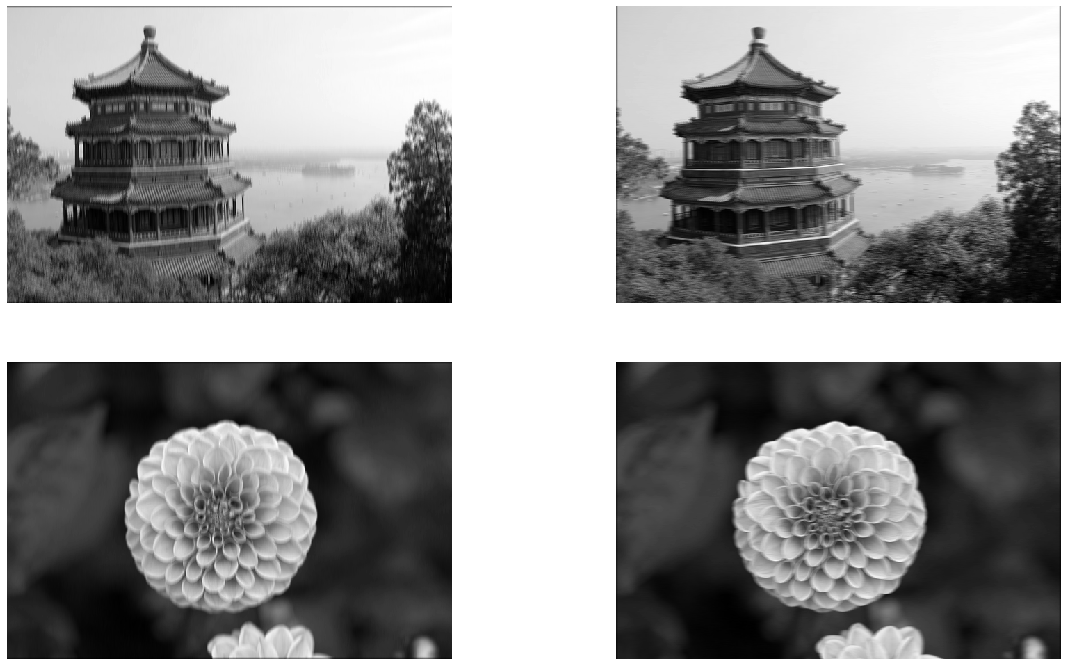

In [5]:
plt.figure(figsize=(20,12))

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [14]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [11]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

2021-12-14 12:42:25.937409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-14 12:42:25.940445: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-12-14 12:42:26.339108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.7562

2021-12-14 12:43:00.975987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 36s 20ms/step - loss: 0.7083 - accuracy: 0.7562 - val_loss: 0.5249 - val_accuracy: 0.8388
Epoch 2/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.4210 - accuracy: 0.8575 - val_loss: 0.3456 - val_accuracy: 0.8774
Epoch 3/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3652 - accuracy: 0.8761 - val_loss: 0.3051 - val_accuracy: 0.8896
Epoch 4/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3332 - accuracy: 0.8874 - val_loss: 0.2967 - val_accuracy: 0.8904
Epoch 5/10
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3097 - accuracy: 0.8954 - val_loss: 0.2996 - val_accuracy: 0.8912
Epoch 6/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.2949 - accuracy: 0.9008 - val_loss: 0.2956 - val_accuracy: 0.8926
Epoch 7/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.2771 - accuracy: 0.9059 - val_loss: 0.2846 - val_accura

2021-12-14 12:48:06.472010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [12]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [13]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

In [14]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 3s 0us/step


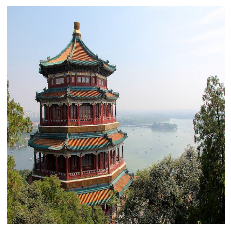

In [15]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


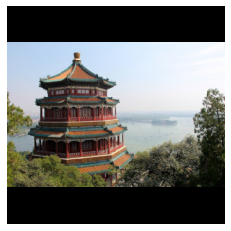

In [16]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

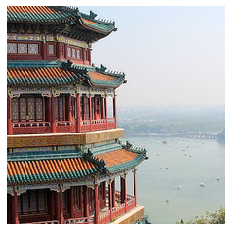

In [17]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

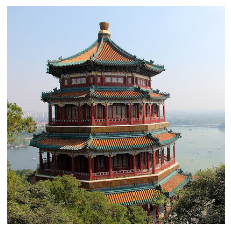

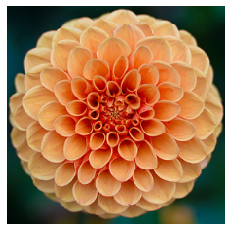

In [18]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [19]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

2021-12-14 13:01:18.325066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

49152/35363 [=========================================] - 0s 2us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



In [6]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

2021-12-14 16:47:46.780708: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Internal: Couldn't parse JSON response from OAuth server.".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /Users/sunkev/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [8]:
n_classes = info.features["label"].num_classes

dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [9]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

2021-12-14 16:50:20.307558: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


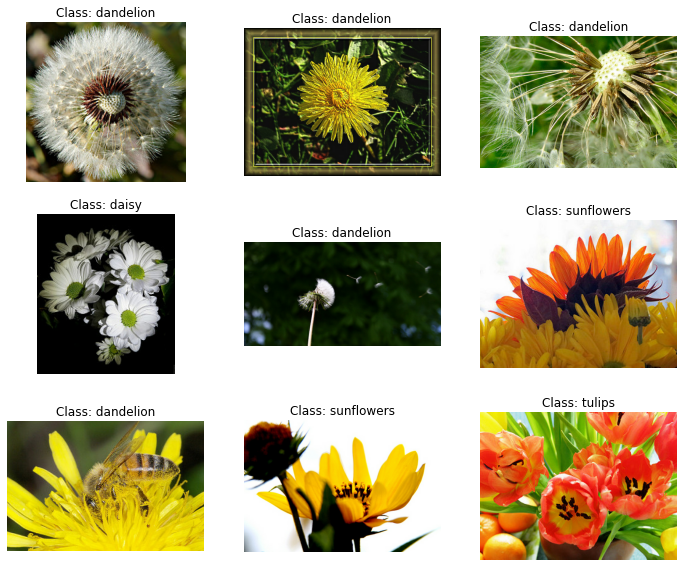

In [12]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [15]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

2021-12-14 16:54:22.244043: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


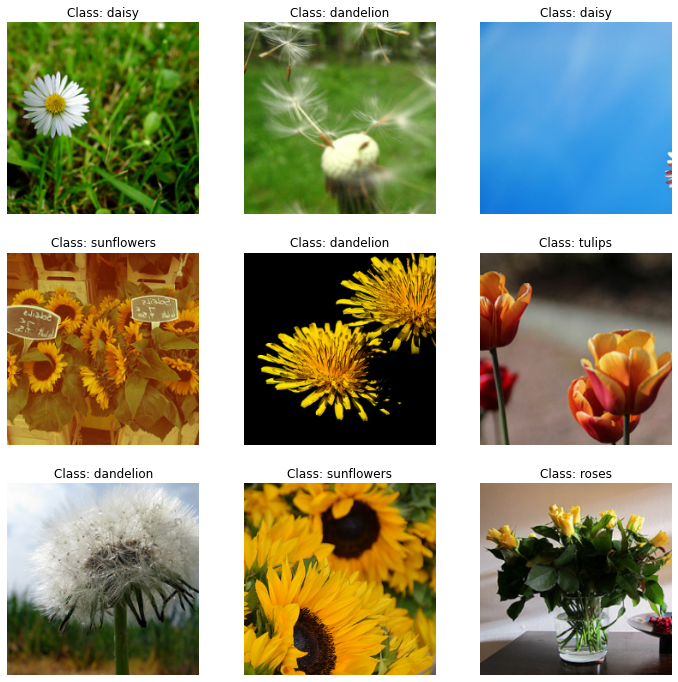

In [16]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

2021-12-14 16:54:43.226175: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


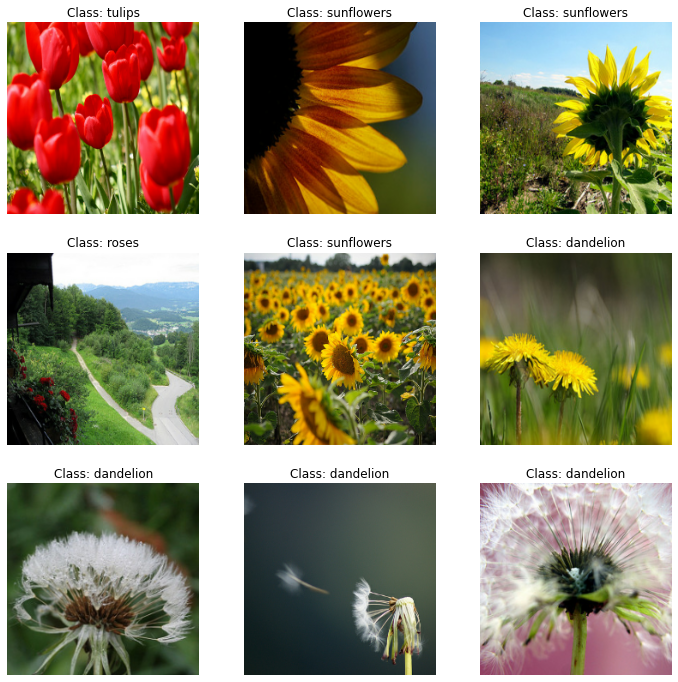

In [17]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [18]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 2s 0us/step


In [19]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

In [20]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


2021-12-14 16:55:47.702227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 1.2652 - accuracy: 0.8020

2021-12-14 16:56:10.337139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 28s 297ms/step - loss: 1.2652 - accuracy: 0.8020 - val_loss: 1.0435 - val_accuracy: 0.8640
Epoch 2/5
86/86 [==============================] - 25s 295ms/step - loss: 0.5369 - accuracy: 0.8986 - val_loss: 0.9753 - val_accuracy: 0.8529
Epoch 3/5
86/86 [==============================] - 25s 293ms/step - loss: 0.3671 - accuracy: 0.9175 - val_loss: 0.8190 - val_accuracy: 0.8787
Epoch 4/5
86/86 [==============================] - 25s 297ms/step - loss: 0.2548 - accuracy: 0.9331 - val_loss: 0.6918 - val_accuracy: 0.8750
Epoch 5/5
86/86 [==============================] - 25s 290ms/step - loss: 0.1610 - accuracy: 0.9539 - val_loss: 0.6888 - val_accuracy: 0.8621


In [21]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40


2021-12-14 16:58:01.086007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8928

2021-12-14 16:59:22.096688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 86s 928ms/step - loss: 0.3458 - accuracy: 0.8928 - val_loss: 0.4434 - val_accuracy: 0.8897
Epoch 2/40
86/86 [==============================] - 80s 930ms/step - loss: 0.1350 - accuracy: 0.9535 - val_loss: 0.4323 - val_accuracy: 0.8713
Epoch 3/40
86/86 [==============================] - 79s 918ms/step - loss: 0.0731 - accuracy: 0.9786 - val_loss: 0.3011 - val_accuracy: 0.9118
Epoch 4/40
86/86 [==============================] - 78s 912ms/step - loss: 0.0371 - accuracy: 0.9891 - val_loss: 0.2777 - val_accuracy: 0.9154
Epoch 5/40
86/86 [==============================] - 78s 910ms/step - loss: 0.0411 - accuracy: 0.9898 - val_loss: 0.3140 - val_accuracy: 0.9099
Epoch 6/40
86/86 [==============================] - 78s 908ms/step - loss: 0.0347 - accuracy: 0.9895 - val_loss: 0.2761 - val_accuracy: 0.9191
Epoch 7/40
86/86 [==============================] - 78s 909ms/step - loss: 0.0179 - accuracy: 0.9935 - val_loss: 0.2949 - val_accuracy: 0.9191
Epoch 8/40

In [25]:
prediction = model.predict(test_set.take(10))
prediction

array([[3.7731924e-13, 2.0172087e-12, 1.0000000e+00, 2.8557341e-15,
        2.5477721e-12],
       [6.7128442e-11, 1.4346199e-10, 2.6521180e-08, 1.0000000e+00,
        9.4094750e-09],
       [1.8298172e-06, 9.8817808e-11, 1.6291270e-07, 9.9999797e-01,
        2.5727911e-11],
       ...,
       [9.9955219e-01, 1.6461458e-07, 7.7755828e-07, 4.4658774e-04,
        2.4914326e-07],
       [3.9907103e-10, 2.1465855e-08, 1.0000000e+00, 2.4750531e-11,
        6.3567684e-10],
       [5.8867866e-09, 4.6141622e-11, 9.3376737e-11, 9.2102975e-12,
        1.0000000e+00]], dtype=float32)

In [27]:
prediction.shape

(320, 5)

In [31]:
tf.math.argmax(prediction, axis=1)

<tf.Tensor: shape=(320,), dtype=int64, numpy=
array([2, 3, 3, 2, 3, 0, 0, 0, 0, 1, 2, 2, 4, 1, 2, 4, 2, 4, 2, 2, 0, 0,
       0, 2, 0, 3, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 3, 0, 4, 2, 3, 0, 4,
       3, 3, 2, 4, 0, 1, 2, 1, 3, 0, 1, 4, 1, 0, 2, 3, 0, 0, 4, 0, 1, 1,
       0, 1, 2, 4, 3, 3, 0, 3, 4, 2, 1, 0, 3, 2, 0, 0, 4, 3, 0, 3, 3, 2,
       0, 2, 1, 4, 0, 3, 3, 3, 1, 4, 0, 4, 4, 4, 4, 0, 4, 2, 3, 4, 0, 0,
       4, 4, 4, 2, 2, 4, 2, 3, 3, 0, 3, 2, 0, 1, 2, 1, 4, 3, 0, 2, 0, 2,
       2, 4, 0, 3, 0, 0, 1, 2, 0, 1, 2, 3, 1, 4, 2, 0, 3, 3, 4, 0, 4, 0,
       4, 0, 4, 2, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0, 4, 1, 1, 4, 3, 1, 0, 1,
       2, 3, 4, 0, 0, 3, 2, 4, 1, 0, 0, 4, 4, 2, 0, 3, 4, 0, 0, 3, 3, 2,
       0, 2, 2, 3, 4, 0, 1, 4, 1, 0, 1, 2, 2, 2, 2, 2, 1, 3, 4, 2, 4, 1,
       0, 0, 4, 2, 1, 0, 3, 2, 1, 4, 3, 1, 3, 0, 0, 2, 3, 4, 0, 1, 2, 4,
       0, 3, 1, 0, 1, 2, 4, 0, 4, 4, 2, 3, 0, 2, 1, 2, 2, 4, 1, 4, 3, 3,
       0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 3, 1, 4, 2, 3, 3, 3, 2, 0, 3, 3,
     